In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!pip uninstall -y wandb
!pip install wandb==0.17.5 
import wandb
!wandb offline
!wandb disabled
import os
os.environ["WANDB_DISABLED"] = "true"

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.5 MB/s eta 0:00:0000:0100:01
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [4]:
!pip install -q datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [6]:
train_ukr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/train/ukr.csv")
train_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/train/ron.csv")


dev_ukr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/dev/ukr.csv")
dev_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/dev/ron.csv")


test_ukr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/test/ukr.csv")
test_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/test/ron.csv")

# UKRAINIAN

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
- https://huggingface.co/ukr-models/xlm-roberta-base-uk
- https://huggingface.co/microsoft/Multilingual-MiniLM-L12-H384
- https://huggingface.co/youscan/ukr-roberta-base

In [12]:
train_ukr.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ukr_train_track_b_00001,Хочу гітару і записувати кавери.,0,0,0,0,0,0
1,ukr_train_track_b_00002,"сенсей зацінив мої поетичні здібності, оце щас...",0,0,0,1,0,0
2,ukr_train_track_b_00003,"мені б снігу трішки на свята для настрою, а та...",0,0,0,0,0,0
3,ukr_train_track_b_00004,Коли ми познайомились і довго після того в теб...,0,0,0,0,0,0
4,ukr_train_track_b_00005,так приємно... не очікувала аж такої реакції)),0,0,0,2,0,2


In [13]:
train_ukr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2466 non-null   object
 1   text      2466 non-null   object
 2   anger     2466 non-null   int64 
 3   disgust   2466 non-null   int64 
 4   fear      2466 non-null   int64 
 5   joy       2466 non-null   int64 
 6   sadness   2466 non-null   int64 
 7   surprise  2466 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 154.2+ KB


<Axes: >

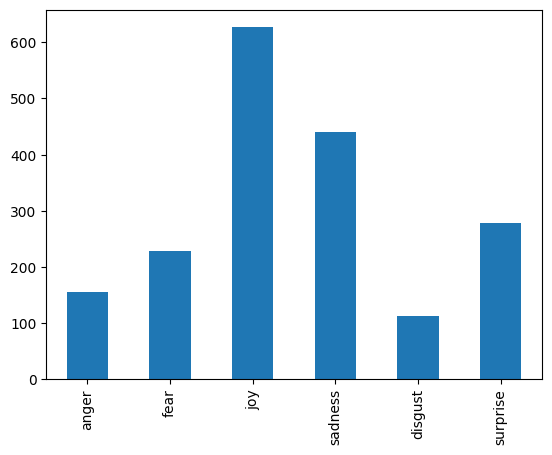

In [14]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust','surprise']
train_ukr[attributes].sum().plot.bar()

<Axes: >

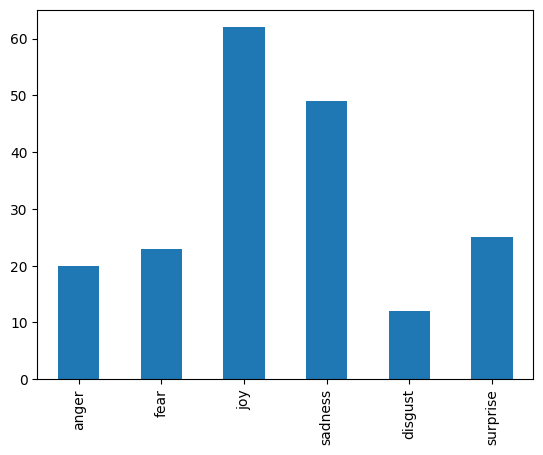

In [15]:
dev_ukr[attributes].sum().plot.bar()

In [16]:
test_ukr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2234 non-null   object 
 1   text      2234 non-null   object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 139.8+ KB


https://huggingface.co/FacebookAI/xlm-roberta-base

In [7]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness","surprise"]

In [9]:
from peft import get_peft_model, LoraConfig, TaskType


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none"  
)

# Twitter XLM RoBERTa Base Sentiment

In [10]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,185,030 || all params: 279,233,292 || trainable%: 0.4244
None


In [13]:
def tokenize_with_emotions(batch):
    emotions = "anger, disgust, fear, joy, sadness, or surprise?"  # Concatenate all emotions
    return tokenizer(emotions, batch['text'], padding=True, truncation=True, max_length=128)

In [14]:
def encode_data_with_demux(df, tokenizer):
    emotions = ["anger", "disgust", "fear", "joy", "sadness","surprise"]
    text_with_emotions = [", ".join(emotions) + "?" + " " + t for t in df['text']]
    encodings = tokenizer(text_with_emotions, truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness',"surprise"]].fillna(0).values
    return encodings, labels

In [15]:
train_encodings, train_labels = encode_data_with_demux(train_ukr, tokenizer)
dev_encodings, dev_labels = encode_data_with_demux(dev_ukr, tokenizer)

In [16]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [17]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [20]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

# Calculate token lengths for your datasets
train_lengths = calculate_token_lengths(train_ukr['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_ukr['text'], tokenizer)
test_lengths = calculate_token_lengths(test_ukr['text'], tokenizer)

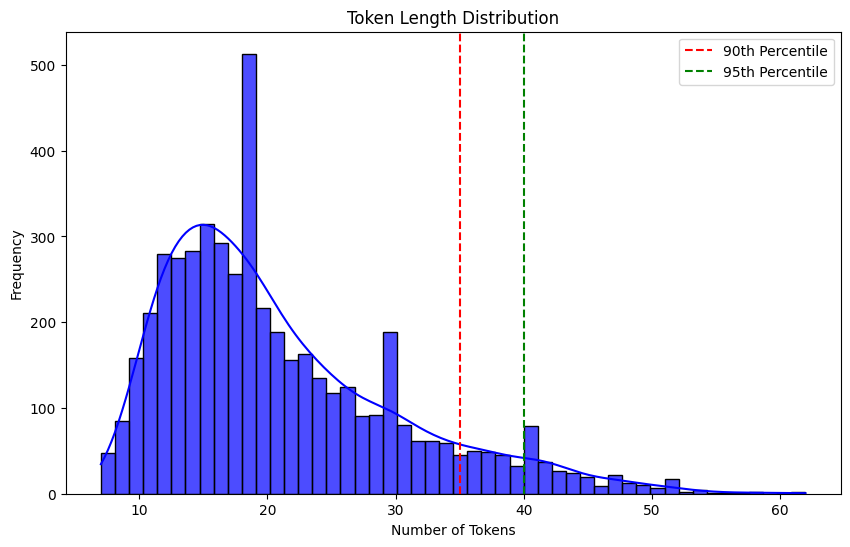

In [21]:
# Combine lengths from all datasets for a global view
all_lengths = train_lengths + dev_lengths + test_lengths

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [18]:
from transformers import EarlyStoppingCallback

In [19]:
correlation_matrix = torch.tensor([
    [1.0, 0.3, 0.5, -0.2, 0.1],  # anger
    [0.3, 1.0, 0.4, -0.1, 0.2],  # disgust
    [0.5, 0.4, 1.0, 0.2, 0.3],   # fear
    [-0.2, -0.1, 0.2, 1.0, -0.4], # joy
    [0.1, 0.2, 0.3, -0.4, 1.0]    # sadness
])

In [20]:
import torch
import torch.nn as nn

class custom_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, labels):
        return self.mse_loss(outputs, labels)

In [21]:
from scipy.stats import pearsonr
import numpy as np

def compute_pearson_corr(predictions, labels):
    """
    Compute Pearson Correlation between predictions and labels.
    """
    # If predictions and labels are torch tensors, convert them to numpy arrays
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    # Calculate Pearson Correlation
    corr, _ = pearsonr(predictions.flatten(), labels.flatten())
    return corr

In [22]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = custom_loss()

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        """
        Custom loss function for the Hugging Face Trainer.
        """
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Extract logits

        # Compute custom loss
        loss = self.loss_fn(logits, labels) 

        return (loss, outputs) if return_outputs else loss

In [23]:
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(p: EvalPrediction):
    """
    Compute metrics for evaluation, including Pearson Correlation, Accuracy, Precision, Recall, and F1 score.
    """
    predictions, labels = p.predictions, p.label_ids
    
    # Rounding predictions to nearest integer for classification
    predictions_rounded = np.round(predictions).astype(int)
    
    # Flatten labels and predictions for metric calculations
    labels_flattened = labels.flatten()
    predictions_flattened = predictions_rounded.flatten()
    
    # Calculate metrics
    pearson_corr = compute_pearson_corr(predictions, labels)
    overall_accuracy = accuracy_score(labels_flattened, predictions_flattened)
    precision = precision_score(labels_flattened, predictions_flattened, average='macro')
    recall = recall_score(labels_flattened, predictions_flattened, average='macro')
    f1 = f1_score(labels_flattened, predictions_flattened, average='macro')
    
    return {
        "pearson_corr": pearson_corr,
        "overall_accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


In [28]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/ukr/xlm-roberta-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [25]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.00001  
)

In [30]:
# Create trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [26]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [32]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.157300,0.169604,0.382965,0.896252,0.293392,0.300916,0.297057
1000,0.152400,0.166117,0.419338,0.900937,0.403793,0.333327,0.341462
1500,0.140300,0.163905,0.449101,0.900937,0.396585,0.351954,0.359254
2000,0.137400,0.155465,0.480968,0.903614,0.412136,0.366349,0.366562
2500,0.128100,0.156437,0.494809,0.906292,0.435068,0.396554,0.396083
3000,0.125200,0.160200,0.498301,0.902276,0.412656,0.395453,0.390835
3500,0.122100,0.155168,0.509318,0.897590,0.412876,0.388041,0.383579
4000,0.119700,0.150490,0.510792,0.906292,0.402569,0.377928,0.377648
4500,0.115900,0.158104,0.513874,0.899598,0.414330,0.394966,0.393091
5000,0.115000,0.156423,0.516015,0.898260,0.410633,0.389880,0.386995


In [33]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [34]:
predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]]


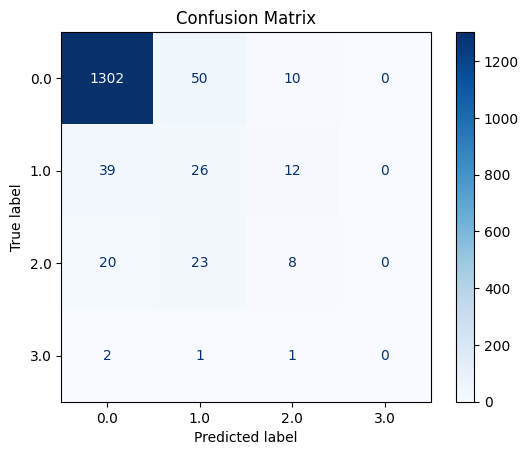

In [35]:
# Flatten the arrays to 1D for confusion matrix
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [37]:
pre=np.round(predictions).astype(int)

In [38]:
predictions = np.array(pre)
labels = np.array(labels)


if predictions.ndim > 1 and labels.ndim > 1:
    accuracies = []
    for i in range(predictions.shape[1]):  # برای هر خروجی
        acc = accuracy_score(labels[:, i], predictions[:, i])
        accuracies.append(acc)
    overall_accuracy = np.mean(accuracies)
else:
    overall_accuracy = accuracy_score(labels, predictions)

print(f"Accuracy: {overall_accuracy:.2f}")

Accuracy: 0.89


In [39]:
test_encodings = tokenizer(list(test_ukr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ukr), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [40]:
test_ukr[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ukr.to_csv('test_predictions_ukr_xlm_roberta_v2.csv', index=False)

# BERT Base Multilingual Cased

In [11]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-cased',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 594,438 || all params: 178,452,492 || trainable%: 0.3331
None


In [24]:
training_args = TrainingArguments(
    output_dir='./results/ukr/bert-base-multi-case-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [26]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [28]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.186000,0.187846,0.202020,0.911647,0.227912,0.250000,0.238445
1000,0.182900,0.181845,0.267364,0.901606,0.267516,0.262563,0.260418
1500,0.172800,0.178037,0.303426,0.894913,0.255960,0.260727,0.257105
2000,0.169700,0.175957,0.320426,0.894244,0.255106,0.260544,0.256786
2500,0.164400,0.175892,0.328116,0.889558,0.255164,0.262322,0.258340
3000,0.163500,0.175071,0.339681,0.888220,0.263243,0.271144,0.267030
3500,0.159600,0.174368,0.336413,0.892905,0.257662,0.263240,0.259699
4000,0.158200,0.172305,0.353541,0.890897,0.259371,0.265752,0.262116
4500,0.156100,0.173598,0.356173,0.889558,0.264999,0.271512,0.267979
5000,0.154300,0.174662,0.352752,0.888889,0.342456,0.222161,0.226337


In [29]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [30]:
predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]]


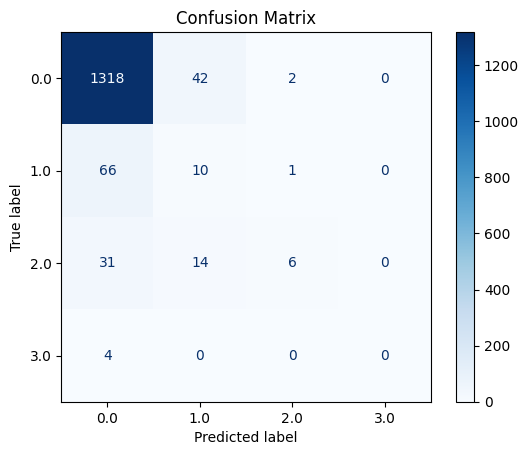

In [31]:
# Flatten the arrays to 1D for confusion matrix
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
pre=np.round(predictions).astype(int)

In [33]:
test_encodings = tokenizer(list(test_ukr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ukr), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [34]:
test_ukr[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ukr.to_csv('test_predictions_ukr_bert_base_multiling_cased_v1.csv', index=False)

# XLM RoBERTa Base

In [9]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,185,030 || all params: 279,233,292 || trainable%: 0.4244
None


In [22]:
training_args = TrainingArguments(
    output_dir='./results/ukr/xlm-roberta-base-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [24]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [26]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.189600,0.190085,0.177682,0.911647,0.227912,0.250000,0.238445
1000,0.179200,0.173616,0.337668,0.904284,0.365676,0.277205,0.282193
1500,0.163500,0.166568,0.406019,0.895582,0.364916,0.299572,0.307909
2000,0.158800,0.162081,0.429608,0.896921,0.389797,0.324444,0.328074
2500,0.148100,0.160645,0.449042,0.894244,0.413604,0.348463,0.350827
3000,0.143400,0.165761,0.457950,0.893574,0.421886,0.391659,0.387524
3500,0.137000,0.153369,0.490262,0.899598,0.411671,0.388098,0.371468
4000,0.133600,0.159981,0.492196,0.894913,0.431117,0.399560,0.389610
4500,0.130900,0.162357,0.495493,0.891566,0.425289,0.409734,0.400307
5000,0.131800,0.155888,0.506798,0.890228,0.402518,0.385775,0.370588


In [27]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [28]:
predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 1 0 1]
 [1 0 0 0 0 0]]


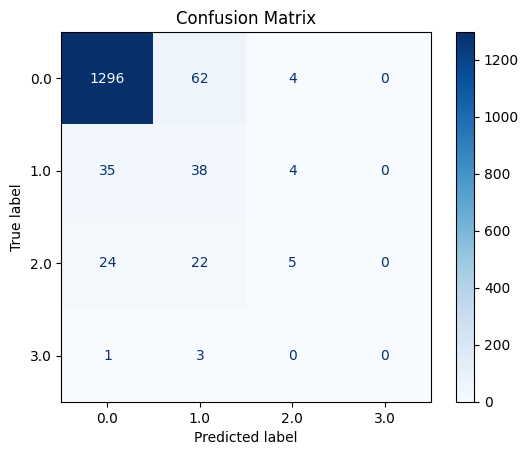

In [29]:
# Flatten the arrays to 1D for confusion matrix
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [30]:
pre=np.round(predictions).astype(int)

In [31]:
test_encodings = tokenizer(list(test_ukr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ukr), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [32]:
test_ukr[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ukr.to_csv('test_predictions_ukr_xlmroberta_base_v1.csv', index=False)

# Multilingual-MiniLM-L12-H384

In [12]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Multilingual-MiniLM-L12-H384")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/Multilingual-MiniLM-L12-H384",
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args = TrainingArguments(
    output_dir='./results/ukr/mMiniLM-L12xH384-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [27]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [28]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.159600,0.167425,0.385416,0.906292,0.282554,0.273037,0.273389
1000,0.144400,0.170016,0.374458,0.902945,0.420629,0.294303,0.313337
1500,0.122300,0.175507,0.408888,0.885542,0.374044,0.346571,0.352649
2000,0.107400,0.172211,0.399373,0.896252,0.366510,0.313663,0.322942
2500,0.082300,0.183894,0.390061,0.886212,0.373264,0.343197,0.342558
3000,0.072800,0.183228,0.436593,0.891566,0.389957,0.369418,0.367133
3500,0.065300,0.181696,0.438134,0.891566,0.359220,0.353855,0.349131
4000,0.057000,0.169729,0.449199,0.902276,0.388724,0.353481,0.349569
4500,0.050100,0.187750,0.432160,0.891566,0.378821,0.369665,0.369645
5000,0.046000,0.181335,0.449192,0.891566,0.375486,0.378855,0.373518


In [29]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [30]:
predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]]


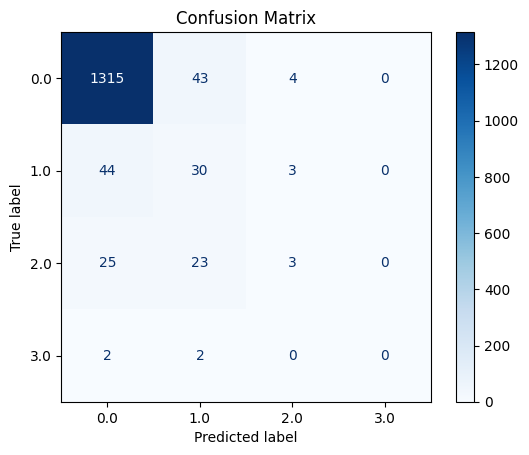

In [31]:
# Flatten the arrays to 1D for confusion matrix
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
pre=np.round(predictions).astype(int)
test_encodings = tokenizer(list(test_ukr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ukr), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [33]:
test_ukr[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ukr.to_csv('test_predictions_ukr_mMiniLM-L12xH384_v1.csv', index=False)